In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import sklearn
import numpy as np
import umap
import openai
from dotenv import find_dotenv, load_dotenv
import re

In [2]:
#openai.api_key
load_dotenv(find_dotenv())

True

In [3]:
tqdm.pandas()

In [4]:
twcs = pd.read_csv('twcs_prepared.csv')
twcs = twcs.dropna(subset=['clean_text'])
twcs = twcs.reset_index(drop=True)
twcs_subset = twcs.sample(n=100000, random_state=42)

In [5]:
twcs_subset.head()

,tweet_id,clean_text
1311682,2611947,whats the price for an account with lines? jus...
796834,1624093,i recently bought a charger form you guys for ...
1444376,2863891,no it is still in all original packaging with ...
663020,1358004,u guys dont support price protection especiall...
1165359,2332065,who can i write to to thank the virgin staff a...


In [6]:
twcs_subset.shape

(100000, 2)

In [7]:
# define train and test dfs
df = twcs_subset.sample(frac=0.85, random_state=42)
test_df = twcs_subset.drop(df.index)

In [8]:
df.shape

(85000, 2)

In [9]:
test_df.shape

(15000, 2)

In [10]:
client = openai.OpenAI()

In [11]:
### Embedding and Dimensionality Reduction

In [12]:
from sentence_transformers import SentenceTransformer

def embeddings_openai(prompt):
    response = client.embeddings.create(
        input=prompt,
        model="text-embedding-ada-002"
    )
    return response.data[0].embedding

In [13]:
"""#df['embeddings'] = df['clean_text'].progress_apply(lambda x: embeddings_openai(x))
#df.to_csv('sample_emb.csv', index=False)"""

"#df['embeddings'] = df['clean_text'].progress_apply(lambda x: embeddings_openai(x))\n#df.to_csv('sample_emb.csv', index=False)"

In [14]:
model_name_hug = 'sentence-transformers/all-mpnet-base-v2'
model = SentenceTransformer(model_name_hug)
text_values = df['clean_text'].tolist()

# Encode text values
embeddings = model.encode(
    text_values, 
    show_progress_bar=True, 
)

# Add a new column 'embeddings' to the DataFrame
df['hug_embeddings'] = list(embeddings)


Batches:   0%|          | 0/2657 [00:00<?, ?it/s]

In [15]:
df.head()

,tweet_id,clean_text,hug_embeddings
366545,760061,im having the same problem with my card im tr...,"[-0.006630308, -0.03410908, 0.014129483, -0.01..."
1210882,2419037,for tickets to stand up for hours leeds lond...,"[-0.0072227665, -0.0022063444, -0.017389687, 0..."
1311959,2612483,any prepacked precut fruit. it seems theres a ...,"[0.06532808, -0.02262792, 0.015571611, -0.0130..."
1127687,2259892,mcdonald run,"[-0.032393742, 0.033859327, -0.006859308, -0.0..."
498761,1027628,thanks i have sent you the dm,"[0.047049806, -0.01865189, -0.030001568, 0.020..."


In [17]:
type(df.hug_embeddings.loc[366545])

numpy.ndarray

In [18]:
#df.to_csv('twcs_hug_emb.csv', index=False)

In [19]:
#df = pd.read_csv('twcs_hug_emb.csv')

In [22]:
# transform string to list
#import ast
#df['hug_embeddings'] = df['hug_embeddings'].apply(ast.literal_eval)

In [23]:
import umap.umap_ as umap

In [24]:
reducer = umap.UMAP()
embedding_list = df['hug_embeddings'].tolist()
embedding_matrix = np.stack(embedding_list, axis=0)
reduced_embeddings = reducer.fit_transform(embedding_matrix, )

df['reduced_hug_embeddings'] = list(reduced_embeddings)


In [25]:
df.head()

,tweet_id,clean_text,hug_embeddings,reduced_hug_embeddings
366545,760061,im having the same problem with my card im tr...,"[-0.006630308, -0.03410908, 0.014129483, -0.01...","[12.958704, 4.9156933]"
1210882,2419037,for tickets to stand up for hours leeds lond...,"[-0.0072227665, -0.0022063444, -0.017389687, 0...","[12.461964, -2.6646166]"
1311959,2612483,any prepacked precut fruit. it seems theres a ...,"[0.06532808, -0.02262792, 0.015571611, -0.0130...","[9.409803, 0.10098898]"
1127687,2259892,mcdonald run,"[-0.032393742, 0.033859327, -0.006859308, -0.0...","[8.405855, -0.4392022]"
498761,1027628,thanks i have sent you the dm,"[0.047049806, -0.01865189, -0.030001568, 0.020...","[15.27981, 4.452145]"


In [36]:
#reduced_df = df[['tweet_id', 'clean_text', 'reduced_hug_embeddings']]
#reduced_df['r_hug_embeddings'] = reduced_df['reduced_hug_embeddings'].apply(list)
#reduced_df = reduced_df.drop('reduced_hug_embeddings', axis=1)
#reduced_df.to_csv('twcs_hug_emb_reduced.csv', index=False)

In [40]:
#df = pd.read_csv('twcs_hug_emb_reduced.csv')
#df = reduced_df.copy()

In [45]:
# transform string to list
#import ast
#df['r_hug_embeddings'] = df['r_hug_embeddings'].apply(ast.literal_eval)
#type(df['r_hug_embeddings'].loc[1])

In [ ]:
### Choose the best n_clusters

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_train = df['reduced_hug_embeddings'].tolist()

n_clusters_range = range(3, 21)

silhouette_scores = []

# (n_clusters, silhouette_score, kmeans)
# starting with score 0 because negative values indicate terrible clusters
clusters = []
cluster_with_max_silhouette = (0, 0, None)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state = 1234, verbose=1)
    cluster_labels = kmeans.fit_predict(X_train)
    print(f"{n_clusters} trained")
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    clusters.append((n_clusters, silhouette_avg, kmeans))
    if silhouette_avg >= cluster_with_max_silhouette[1]:
        cluster_with_max_silhouette = (n_clusters, silhouette_avg, kmeans)


C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 954820.4929017528.
Iteration 1, inertia 891935.6774845673.
Iteration 2, inertia 875885.8890611843.
Iteration 3, inertia 862430.1593183042.
Iteration 4, inertia 850242.5770276625.
Iteration 5, inertia 844872.34249039.
Iteration 6, inertia 842022.5255034033.
Iteration 7, inertia 840550.7123878661.
Iteration 8, inertia 839929.0719769455.
Iteration 9, inertia 839728.4639269056.
Iteration 10, inertia 839641.6861237544.
Converged at iteration 10: center shift 0.0007631030750088133 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 1245351.0174367256.
Iteration 1, inertia 896178.7031850144.
Iteration 2, inertia 883109.3177028662.
Iteration 3, inertia 875759.8809828472.
Iteration 4, inertia 868538.1881009552.
Iteration 5, inertia 857632.6311046828.
Iteration 6, inertia 848951.5730228208.
Iteration 7, inertia 845433.8876700101.
Iteration 8, inertia 842411.4273513446.
Iteration 9, inertia 840620.9908601815.
Iteration 

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 855835.4529974225.
Iteration 1, inertia 769144.9829494206.
Iteration 2, inertia 749228.7452014545.
Iteration 3, inertia 735291.5498947502.
Iteration 4, inertia 723165.8172924048.
Iteration 5, inertia 717771.6199530488.
Iteration 6, inertia 715487.0734751653.
Iteration 7, inertia 714147.3872255876.
Iteration 8, inertia 712624.3961254635.
Iteration 9, inertia 708787.4823077945.
Iteration 10, inertia 701368.209204045.
Iteration 11, inertia 689956.7000609194.
Iteration 12, inertia 676119.4211446124.
Iteration 13, inertia 661650.161426211.
Iteration 14, inertia 650588.7151159949.
Iteration 15, inertia 642927.9549046918.
Iteration 16, inertia 640995.57455761.
Iteration 17, inertia 640598.7072721596.
Iteration 18, inertia 640517.6615226701.
Converged at iteration 18: center shift 0.0006268640792413449 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 684581.5924325354.
Iteration 1, inertia 646247.9023548842.
Itera

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 616110.2229239992.
Iteration 1, inertia 574350.003475566.
Iteration 2, inertia 564293.089980291.
Iteration 3, inertia 552099.8244085383.
Iteration 4, inertia 546133.7873785347.
Iteration 5, inertia 544125.447488698.
Iteration 6, inertia 543208.0150382369.
Iteration 7, inertia 542508.5952719933.
Iteration 8, inertia 541796.6015128945.
Iteration 9, inertia 541200.7696318643.
Iteration 10, inertia 540932.8743532067.
Iteration 11, inertia 540845.4250885774.
Converged at iteration 11: center shift 0.0007975644361721394 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 656967.9590277664.
Iteration 1, inertia 575169.2490338677.
Iteration 2, inertia 570370.1507162959.
Iteration 3, inertia 567819.2908342953.
Iteration 4, inertia 566368.9873470778.
Iteration 5, inertia 565546.3660601921.
Iteration 6, inertia 565157.042152112.
Iteration 7, inertia 564949.7812587874.
Iteration 8, inertia 564818.1607804864.
Iteration 9,

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 539812.060085071.
Iteration 1, inertia 507043.49984765786.
Iteration 2, inertia 501529.48064647167.
Iteration 3, inertia 496017.0633327123.
Iteration 4, inertia 493791.73801242595.
Iteration 5, inertia 491898.7979527055.
Iteration 6, inertia 490223.51592298073.
Iteration 7, inertia 489513.1575780313.
Iteration 8, inertia 489206.8578492928.
Iteration 9, inertia 489008.2745644521.
Iteration 10, inertia 488822.3159218166.
Iteration 11, inertia 488630.5021370054.
Iteration 12, inertia 488503.3080981812.
Iteration 13, inertia 488382.8760832629.
Iteration 14, inertia 488256.1896713655.
Iteration 15, inertia 488126.60047903436.
Iteration 16, inertia 487938.79958880035.
Iteration 17, inertia 487662.31617756875.
Iteration 18, inertia 487357.18017015397.
Iteration 19, inertia 487038.95963658544.
Iteration 20, inertia 486675.6240514383.
Iteration 21, inertia 486106.5933852102.
Iteration 22, inertia 485375.7786777676.
Iteration 23, inertia 484648.801216

Iteration 19, inertia 462076.28341385996.
Iteration 20, inertia 460274.88292992313.
Iteration 21, inertia 460043.0352729886.
Iteration 22, inertia 460027.4446534621.
Converged at iteration 22: center shift 0.00020890503739078917 within tolerance 0.0010648085550738183.


C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 464159.8958936885.
Iteration 1, inertia 429545.43742021744.
Iteration 2, inertia 427552.6133519933.
Iteration 3, inertia 426583.3564124979.
Iteration 4, inertia 425840.3384999441.
Iteration 5, inertia 425512.6326479518.
Iteration 6, inertia 425290.1229627499.
Iteration 7, inertia 425128.2753183217.
Iteration 8, inertia 425002.2096756623.
Iteration 9, inertia 424928.0084414275.
Iteration 10, inertia 424889.14002720214.
Converged at iteration 10: center shift 0.000765438392913423 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 497928.5349091262.
Iteration 1, inertia 415857.2669893009.
Iteration 2, inertia 407319.66479435796.
Iteration 3, inertia 404359.22412454843.
Iteration 4, inertia 402970.0912067886.
Iteration 5, inertia 402200.0851138087.
Iteration 6, inertia 401508.9843335329.
Iteration 7, inertia 400835.70473900763.
Iteration 8, inertia 400267.81470000325.
Iteration 9, inertia 399764.4280745243.
Iter

Iteration 16, inertia 422928.5019984773.
Converged at iteration 16: center shift 0.0009100188976716093 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 495377.2335856642.
Iteration 1, inertia 440252.6832173291.
Iteration 2, inertia 427602.6884334261.
Iteration 3, inertia 422757.5512614687.
Iteration 4, inertia 419117.0570461207.
Iteration 5, inertia 417438.1168932207.
Iteration 6, inertia 416080.2398108601.
Iteration 7, inertia 414872.0045643861.
Iteration 8, inertia 414200.43173548765.
Iteration 9, inertia 413918.9377677548.
Iteration 10, inertia 413773.3419816824.
Iteration 11, inertia 413656.2693283338.
Iteration 12, inertia 413476.1768017242.
Iteration 13, inertia 413362.381807805.
Iteration 14, inertia 413297.9238462074.
Iteration 15, inertia 413267.1296574197.
Converged at iteration 15: center shift 0.0006290761507843778 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 521074.6756259664.
Iteration 1, inertia 

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 410992.9907183377.
Iteration 1, inertia 355015.94866110635.
Iteration 2, inertia 346509.64130579674.
Iteration 3, inertia 341133.39998808975.
Iteration 4, inertia 339204.54215033306.
Iteration 5, inertia 338772.2433420991.
Iteration 6, inertia 338600.81356541376.
Iteration 7, inertia 338482.81846604776.
Iteration 8, inertia 338417.7701430496.
Iteration 9, inertia 338372.1212326431.
Iteration 10, inertia 338331.321940448.
Iteration 11, inertia 338292.0026237854.
Iteration 12, inertia 338255.6930530335.
Converged at iteration 12: center shift 0.0009883148968861145 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 422244.04357310897.
Iteration 1, inertia 382166.912903115.
Iteration 2, inertia 371335.0713822857.
Iteration 3, inertia 361992.92420586.
Iteration 4, inertia 355480.23557350435.
Iteration 5, inertia 349925.47804577084.
Iteration 6, inertia 347034.8974572821.
Iteration 7, inertia 345792.1115273417.
It

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 360957.85086991964.
Iteration 1, inertia 312438.6525376742.
Iteration 2, inertia 308475.3648485154.
Iteration 3, inertia 305808.7055623629.
Iteration 4, inertia 302904.44097782.
Iteration 5, inertia 297483.80894655705.
Iteration 6, inertia 293539.27994454914.
Iteration 7, inertia 286218.35907333624.
Iteration 8, inertia 273305.6401475126.
Iteration 9, inertia 269717.1294143812.
Iteration 10, inertia 268424.5833149995.
Iteration 11, inertia 267820.6045341158.
Iteration 12, inertia 267633.50818246807.
Iteration 13, inertia 267574.8858908603.
Converged at iteration 13: center shift 0.001002902859520863 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 356027.8763005935.
Iteration 1, inertia 322044.1288987954.
Iteration 2, inertia 314474.3734459395.
Iteration 3, inertia 311257.4655070459.
Iteration 4, inertia 308845.5181018829.
Iteration 5, inertia 306777.9212771093.
Iteration 6, inertia 304962.62068076816.
Ite

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 303895.4010589746.
Iteration 1, inertia 255201.03855837774.
Iteration 2, inertia 251004.20950121872.
Iteration 3, inertia 249239.1001103393.
Iteration 4, inertia 248027.69277436743.
Iteration 5, inertia 247089.45491352075.
Iteration 6, inertia 246379.8482842603.
Iteration 7, inertia 245667.8172051654.
Iteration 8, inertia 244851.67512068362.
Iteration 9, inertia 244118.4967362923.
Iteration 10, inertia 243470.3403249589.
Iteration 11, inertia 242999.92921117906.
Iteration 12, inertia 242848.22700677137.
Iteration 13, inertia 242767.30821910902.
Iteration 14, inertia 242690.99491210247.
Iteration 15, inertia 242618.5256670488.
Iteration 16, inertia 242548.3113688422.
Iteration 17, inertia 242494.32857397496.
Iteration 18, inertia 242461.48600500874.
Converged at iteration 18: center shift 0.0010373553703783636 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 298039.7438352222.
Iteration 1, inertia 257812.24

Iteration 15, inertia 241759.00086176087.
Iteration 16, inertia 241694.4353917613.
Iteration 17, inertia 241619.06164783228.
Iteration 18, inertia 241551.1021116458.
Iteration 19, inertia 241504.31025692768.
Iteration 20, inertia 241476.5210610358.
Converged at iteration 20: center shift 0.0009476409145458692 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 269359.5566355618.
Iteration 1, inertia 245734.5019647027.
Iteration 2, inertia 244599.8946231521.
Iteration 3, inertia 244003.78000803434.
Iteration 4, inertia 243242.46516492116.
Iteration 5, inertia 242726.39773075635.
Iteration 6, inertia 242286.2187967814.
Iteration 7, inertia 241963.9925856652.
Iteration 8, inertia 241780.16891606268.
Iteration 9, inertia 241640.55881743578.
Iteration 10, inertia 241533.25585057487.
Iteration 11, inertia 241452.59293884202.
Iteration 12, inertia 241377.2869576247.
Iteration 13, inertia 241323.91095545562.
Iteration 14, inertia 241295.82708474924.
Converged a

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 292671.26353872556.
Iteration 1, inertia 241230.0578075487.
Iteration 2, inertia 227736.25663834857.
Iteration 3, inertia 222657.92597720685.
Iteration 4, inertia 220699.9781359833.
Iteration 5, inertia 219477.36062865492.
Iteration 6, inertia 217165.51773548004.
Iteration 7, inertia 215015.30643271722.
Iteration 8, inertia 213005.03539941966.
Iteration 9, inertia 212423.6907627149.
Iteration 10, inertia 212148.4687025831.
Iteration 11, inertia 211897.7281886418.
Iteration 12, inertia 211683.74433724213.
Iteration 13, inertia 211543.62343187336.
Iteration 14, inertia 211471.04450493067.
Iteration 15, inertia 211441.3235968881.
Converged at iteration 15: center shift 0.0008892549266525475 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 237185.75005706405.
Iteration 1, inertia 216009.92882592013.
Iteration 2, inertia 213367.45701048023.
Iteration 3, inertia 212555.97526819925.
Iteration 4, inertia 212180.81

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 265689.11297436163.
Iteration 1, inertia 216616.760105779.
Iteration 2, inertia 206130.4496064457.
Iteration 3, inertia 200253.32273271965.
Iteration 4, inertia 198527.53929910244.
Iteration 5, inertia 197560.58176204126.
Iteration 6, inertia 196693.35419730333.
Iteration 7, inertia 195804.886247445.
Iteration 8, inertia 194891.86553236042.
Iteration 9, inertia 193869.5607045399.
Iteration 10, inertia 192475.14705355302.
Iteration 11, inertia 191378.55124621547.
Iteration 12, inertia 190730.64978117053.
Iteration 13, inertia 190277.99727326503.
Iteration 14, inertia 189920.4494416935.
Iteration 15, inertia 189669.05905911222.
Iteration 16, inertia 189526.6225889752.
Iteration 17, inertia 189455.3086439931.
Iteration 18, inertia 189386.95708784115.
Iteration 19, inertia 189344.80658211172.
Iteration 20, inertia 189308.638856864.
Iteration 21, inertia 189267.06637541778.
Iteration 22, inertia 189202.73725822315.
Iteration 23, inertia 189146.50

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 225916.46878238494.
Iteration 1, inertia 192150.4412925283.
Iteration 2, inertia 181814.210422003.
Iteration 3, inertia 175014.28064668883.
Iteration 4, inertia 172525.46638577175.
Iteration 5, inertia 171443.06899275878.
Iteration 6, inertia 170778.8980535833.
Iteration 7, inertia 170271.01910680643.
Iteration 8, inertia 169926.9808711275.
Iteration 9, inertia 169772.41336855726.
Iteration 10, inertia 169707.28834726423.
Iteration 11, inertia 169681.57130501856.
Converged at iteration 11: center shift 0.0008174512639629841 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 229918.72067679412.
Iteration 1, inertia 192058.28809280766.
Iteration 2, inertia 179096.94035982553.
Iteration 3, inertia 172775.99858294654.
Iteration 4, inertia 168822.4112414894.
Iteration 5, inertia 166703.5348717261.
Iteration 6, inertia 165795.91959341074.
Iteration 7, inertia 165409.0900168019.
Iteration 8, inertia 165256.47154803

Iteration 0, inertia 227414.1767571705.
Iteration 1, inertia 185565.49693648322.
Iteration 2, inertia 179041.58859986262.
Iteration 3, inertia 176494.11435589567.
Iteration 4, inertia 174727.27535479158.
Iteration 5, inertia 173122.1028648902.
Iteration 6, inertia 171458.25852619158.
Iteration 7, inertia 170005.84379586767.
Iteration 8, inertia 169022.86018432665.
Iteration 9, inertia 167626.83966795588.
Iteration 10, inertia 165981.7892405496.
Iteration 11, inertia 164645.4243323166.
Iteration 12, inertia 164090.80648455492.
Iteration 13, inertia 164020.55596489413.
Converged at iteration 13: center shift 0.000840671849693509 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 220066.3000922351.
Iteration 1, inertia 192786.68807684825.
Iteration 2, inertia 186655.83440818705.
Iteration 3, inertia 182360.4275646166.
Iteration 4, inertia 178514.87424842216.
Iteration 5, inertia 174958.0926898929.
Iteration 6, inertia 172492.95952682928.
Iteration 7, iner

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 205896.0090864459.
Iteration 1, inertia 168240.84414707034.
Iteration 2, inertia 158714.9836324956.
Iteration 3, inertia 153142.89090011615.
Iteration 4, inertia 151497.50272338238.
Iteration 5, inertia 150705.0794763769.
Iteration 6, inertia 150122.4855437365.
Iteration 7, inertia 149590.9375598689.
Iteration 8, inertia 149163.17485622337.
Iteration 9, inertia 148981.5017118493.
Iteration 10, inertia 148898.18152918274.
Iteration 11, inertia 148862.55296580296.
Iteration 12, inertia 148848.43355075308.
Converged at iteration 12: center shift 0.0004461535146708847 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 212652.29840004712.
Iteration 1, inertia 195519.68435820658.
Iteration 2, inertia 187021.90838750594.
Iteration 3, inertia 180408.01987719405.
Iteration 4, inertia 177273.61886966717.
Iteration 5, inertia 175289.28293435735.
Iteration 6, inertia 172939.1501964903.
Iteration 7, inertia 170024.274949

Initialization complete
Iteration 0, inertia 226886.34953062714.
Iteration 1, inertia 173183.6078954993.
Iteration 2, inertia 167138.95425825028.
Iteration 3, inertia 163814.2204501058.
Iteration 4, inertia 161653.25513926678.
Iteration 5, inertia 160598.50789272707.
Iteration 6, inertia 159872.66598323392.
Iteration 7, inertia 159350.3982850061.
Iteration 8, inertia 159033.39953905638.
Iteration 9, inertia 158825.0989903005.
Iteration 10, inertia 158692.94797451075.
Iteration 11, inertia 158611.55877090487.
Iteration 12, inertia 158559.44780310863.
Iteration 13, inertia 158510.7856581567.
Iteration 14, inertia 158465.627009345.
Iteration 15, inertia 158370.46243385642.
Iteration 16, inertia 158127.53539413871.
Iteration 17, inertia 157467.16823414539.
Iteration 18, inertia 156471.88010784765.
Iteration 19, inertia 155545.82693500686.
Iteration 20, inertia 154883.3747194707.
Iteration 21, inertia 154563.86180548352.
Iteration 22, inertia 154446.13983350046.
Iteration 23, inertia 154385

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 191731.63419256255.
Iteration 1, inertia 154171.84252796826.
Iteration 2, inertia 144068.33652954825.
Iteration 3, inertia 137939.4627566789.
Iteration 4, inertia 135872.05404579776.
Iteration 5, inertia 134671.2028860555.
Iteration 6, inertia 133748.88037101977.
Iteration 7, inertia 132920.03594007995.
Iteration 8, inertia 132339.1485062977.
Iteration 9, inertia 132058.6813219087.
Iteration 10, inertia 131929.40485681762.
Iteration 11, inertia 131885.50822941292.
Iteration 12, inertia 131861.03909076523.
Converged at iteration 12: center shift 0.0007759393579029832 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 185106.44744712973.
Iteration 1, inertia 165337.02902398029.
Iteration 2, inertia 157470.92187902678.
Iteration 3, inertia 152659.89519003322.
Iteration 4, inertia 148886.56577737237.
Iteration 5, inertia 146839.86765374098.
Iteration 6, inertia 146269.1434261012.
Iteration 7, inertia 145962.1622

Initialization complete
Iteration 0, inertia 219661.18669999618.
Iteration 1, inertia 164282.64286202606.
Iteration 2, inertia 160145.76251542845.
Iteration 3, inertia 157892.1300347457.
Iteration 4, inertia 155291.93402980914.
Iteration 5, inertia 153217.023346983.
Iteration 6, inertia 152008.6989854493.
Iteration 7, inertia 151290.72433673555.
Iteration 8, inertia 150847.2897815382.
Iteration 9, inertia 150545.73000711936.
Iteration 10, inertia 150383.03855594338.
Iteration 11, inertia 150289.09120311603.
Iteration 12, inertia 150239.57527642208.
Iteration 13, inertia 150213.9451619421.
Iteration 14, inertia 150197.9007599768.
Converged at iteration 14: center shift 0.0007366588877929901 within tolerance 0.0010648085550738183.


C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 170988.72599925112.
Iteration 1, inertia 149454.09251270987.
Iteration 2, inertia 140706.9227137306.
Iteration 3, inertia 134938.7528598704.
Iteration 4, inertia 132013.74145875653.
Iteration 5, inertia 129055.70275869739.
Iteration 6, inertia 127001.79940079043.
Iteration 7, inertia 125674.98621693051.
Iteration 8, inertia 124853.6481018065.
Iteration 9, inertia 124459.78084448127.
Iteration 10, inertia 124277.08957603683.
Iteration 11, inertia 124200.97490300353.
Iteration 12, inertia 124159.20130553488.
Iteration 13, inertia 124137.85851214165.
Converged at iteration 13: center shift 0.0006387581017942693 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 156183.5567182571.
Iteration 1, inertia 135610.9667986867.
Iteration 2, inertia 133199.81163444128.
Iteration 3, inertia 131522.69519580455.
Iteration 4, inertia 130607.14305934483.
Iteration 5, inertia 129548.62957336708.
Iteration 6, inertia 128912.187

Iteration 11, inertia 125861.33465947874.
Iteration 12, inertia 125360.40184784615.
Iteration 13, inertia 125027.46024317225.
Iteration 14, inertia 124816.45154644731.
Iteration 15, inertia 124661.04404465588.
Iteration 16, inertia 124570.25659852804.
Iteration 17, inertia 124521.55659867924.
Iteration 18, inertia 124501.0712738542.
Converged at iteration 18: center shift 0.00078324951518779 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 169171.2537531067.
Iteration 1, inertia 131364.52621525136.
Iteration 2, inertia 126679.34680789705.
Iteration 3, inertia 125389.13106338578.
Iteration 4, inertia 124808.20574653798.
Iteration 5, inertia 124457.13774836097.
Iteration 6, inertia 124290.09124926667.
Iteration 7, inertia 124208.28847248363.
Iteration 8, inertia 124170.40393131197.
Iteration 9, inertia 124147.49260932507.
Iteration 10, inertia 124128.01493738656.
Iteration 11, inertia 124109.60759452498.
Iteration 12, inertia 124094.94488486406.
Conver

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 158024.97105796446.
Iteration 1, inertia 138127.86696320976.
Iteration 2, inertia 132108.7020318989.
Iteration 3, inertia 127314.33595316534.
Iteration 4, inertia 125056.42272338885.
Iteration 5, inertia 123624.2418485212.
Iteration 6, inertia 121270.84967368639.
Iteration 7, inertia 119458.82526098589.
Iteration 8, inertia 118374.9988603155.
Iteration 9, inertia 117696.21894356346.
Iteration 10, inertia 117356.633918444.
Iteration 11, inertia 117164.02160436338.
Iteration 12, inertia 117037.02434881344.
Iteration 13, inertia 116953.3215864291.
Iteration 14, inertia 116893.26935476066.
Iteration 15, inertia 116855.43988485062.
Iteration 16, inertia 116829.43902689358.
Iteration 17, inertia 116806.60595954194.
Iteration 18, inertia 116786.99996078327.
Iteration 19, inertia 116770.05141985806.
Iteration 20, inertia 116755.17321799627.
Iteration 21, inertia 116743.52407936727.
Converged at iteration 21: center shift 0.0008971929898019392 within

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 149317.83153242193.
Iteration 1, inertia 130677.29333762192.
Iteration 2, inertia 124814.10307006273.
Iteration 3, inertia 120302.88266871372.
Iteration 4, inertia 117094.59185685283.
Iteration 5, inertia 115544.25055062083.
Iteration 6, inertia 114567.57964451352.
Iteration 7, inertia 113928.60066041791.
Iteration 8, inertia 113442.8493170725.
Iteration 9, inertia 113017.13080868422.
Iteration 10, inertia 112681.10362127848.
Iteration 11, inertia 112460.0485996876.
Iteration 12, inertia 112328.76076382594.
Iteration 13, inertia 112255.87621150982.
Iteration 14, inertia 112216.04660048743.
Iteration 15, inertia 112192.0498024906.
Converged at iteration 15: center shift 0.0010565097683024954 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 148032.46305092482.
Iteration 1, inertia 119506.0276305061.
Iteration 2, inertia 112621.99904602054.
Iteration 3, inertia 111207.4809977696.
Iteration 4, inertia 110762.9

Iteration 18, inertia 109263.95570774598.
Iteration 19, inertia 109240.45862179657.
Iteration 20, inertia 109222.67892417326.
Iteration 21, inertia 109209.72977605202.
Converged at iteration 21: center shift 0.000989529269227958 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 142811.3828492746.
Iteration 1, inertia 122667.77704599997.
Iteration 2, inertia 119965.09335341777.
Iteration 3, inertia 119228.57614998853.
Iteration 4, inertia 118921.27228175066.
Iteration 5, inertia 118725.53767620107.
Iteration 6, inertia 118528.33290864565.
Iteration 7, inertia 118270.97244745177.
Iteration 8, inertia 117812.12600684148.
Iteration 9, inertia 117023.71955576536.
Iteration 10, inertia 115433.22071795442.
Iteration 11, inertia 112644.77307732796.
Iteration 12, inertia 110286.35337626704.
Iteration 13, inertia 109164.50141335804.
Iteration 14, inertia 108833.06444580307.
Iteration 15, inertia 108723.23086752045.
Iteration 16, inertia 108668.89455359038.
Iter

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 139268.27320849526.
Iteration 1, inertia 122911.40598009844.
Iteration 2, inertia 115744.72057190219.
Iteration 3, inertia 110241.58472483269.
Iteration 4, inertia 107099.00994854113.
Iteration 5, inertia 105763.80798432413.
Iteration 6, inertia 105028.00411836307.
Iteration 7, inertia 104643.92134883693.
Iteration 8, inertia 104488.79501701427.
Iteration 9, inertia 104436.56623123868.
Iteration 10, inertia 104416.93898302258.
Converged at iteration 10: center shift 0.0010543922243609369 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 133486.8443862506.
Iteration 1, inertia 113809.90792838242.
Iteration 2, inertia 109963.54450311625.
Iteration 3, inertia 106978.33687304413.
Iteration 4, inertia 105701.3098261339.
Iteration 5, inertia 104685.76542861087.
Iteration 6, inertia 104182.03892531458.
Iteration 7, inertia 103842.90804881699.
Iteration 8, inertia 103600.31048503015.
Iteration 9, inertia 103370.214

Initialization complete
Iteration 0, inertia 130007.74485841347.
Iteration 1, inertia 111302.94434433518.
Iteration 2, inertia 106581.74792340914.
Iteration 3, inertia 104511.31793712919.
Iteration 4, inertia 103552.14816477685.
Iteration 5, inertia 103108.56285387301.
Iteration 6, inertia 102843.88160117758.
Iteration 7, inertia 102682.1014434809.
Iteration 8, inertia 102571.55838129202.
Iteration 9, inertia 102491.16048616577.
Iteration 10, inertia 102416.0838298826.
Iteration 11, inertia 102336.22916699482.
Iteration 12, inertia 102282.30346726142.
Iteration 13, inertia 102246.50415690505.
Iteration 14, inertia 102210.18288906605.
Iteration 15, inertia 102183.54794189463.
Iteration 16, inertia 102160.48357479215.
Iteration 17, inertia 102130.72126120391.
Iteration 18, inertia 102112.64870919564.
Converged at iteration 18: center shift 0.0008948406414289381 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 160222.55059503947.
Iteration 1, inertia 13

C:\Users\Polina\.conda\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 129541.89045941347.
Iteration 1, inertia 110669.36037285169.
Iteration 2, inertia 104179.38228836107.
Iteration 3, inertia 99839.89625807224.
Iteration 4, inertia 98272.33201215153.
Iteration 5, inertia 97732.97674941276.
Iteration 6, inertia 97436.2457787067.
Iteration 7, inertia 97183.6358882854.
Iteration 8, inertia 97050.8573378051.
Iteration 9, inertia 97007.16781971126.
Iteration 10, inertia 96990.56058563342.
Converged at iteration 10: center shift 0.0009220203765086083 within tolerance 0.0010648085550738183.
Initialization complete
Iteration 0, inertia 129253.74227507746.
Iteration 1, inertia 114241.5298371362.
Iteration 2, inertia 110970.27272238486.
Iteration 3, inertia 109165.42305397273.
Iteration 4, inertia 107830.33710233055.
Iteration 5, inertia 106641.2107213815.
Iteration 6, inertia 105414.1899736185.
Iteration 7, inertia 104323.64273807124.
Iteration 8, inertia 103800.33186752912.
Iteration 9, inertia 103624.96342643235.
It

Initialization complete
Iteration 0, inertia 152517.21121516527.
Iteration 1, inertia 110845.51367990825.
Iteration 2, inertia 104216.90496772791.
Iteration 3, inertia 101867.20710327054.
Iteration 4, inertia 100122.45602986288.
Iteration 5, inertia 99144.2316104543.
Iteration 6, inertia 98813.76747346924.
Iteration 7, inertia 98729.72382663598.
Iteration 8, inertia 98699.49584353891.
Iteration 9, inertia 98684.07936803582.
Converged at iteration 9: center shift 0.0009837253604553587 within tolerance 0.0010648085550738183.


In [32]:
cluster_with_max_silhouette

(19, 0.42643654, KMeans(n_clusters=19, random_state=1234, verbose=1))

In [34]:
clusters

[(3, 0.33775264, KMeans(n_clusters=3, random_state=1234, verbose=1)),
 (4, 0.3664495, KMeans(n_clusters=4, random_state=1234, verbose=1)),
 (5, 0.38655353, KMeans(n_clusters=5, random_state=1234, verbose=1)),
 (6, 0.40118244, KMeans(n_clusters=6, random_state=1234, verbose=1)),
 (7, 0.38541624, KMeans(n_clusters=7, random_state=1234, verbose=1)),
 (8, 0.40697172, KMeans(random_state=1234, verbose=1)),
 (9, 0.38146853, KMeans(n_clusters=9, random_state=1234, verbose=1)),
 (10, 0.387031, KMeans(n_clusters=10, random_state=1234, verbose=1)),
 (11, 0.4021106, KMeans(n_clusters=11, random_state=1234, verbose=1)),
 (12, 0.41324693, KMeans(n_clusters=12, random_state=1234, verbose=1)),
 (13, 0.41357803, KMeans(n_clusters=13, random_state=1234, verbose=1)),
 (14, 0.4242898, KMeans(n_clusters=14, random_state=1234, verbose=1)),
 (15, 0.4187192, KMeans(n_clusters=15, random_state=1234, verbose=1)),
 (16, 0.41310757, KMeans(n_clusters=16, random_state=1234, verbose=1)),
 (17, 0.41095138, KMeans(n

In [35]:
import pickle

for cluster in clusters:
    with open(f"models/kmeans{cluster[0]}.pkl", "wb") as f:
        pickle.dump(f"kmeans{cluster}", f)

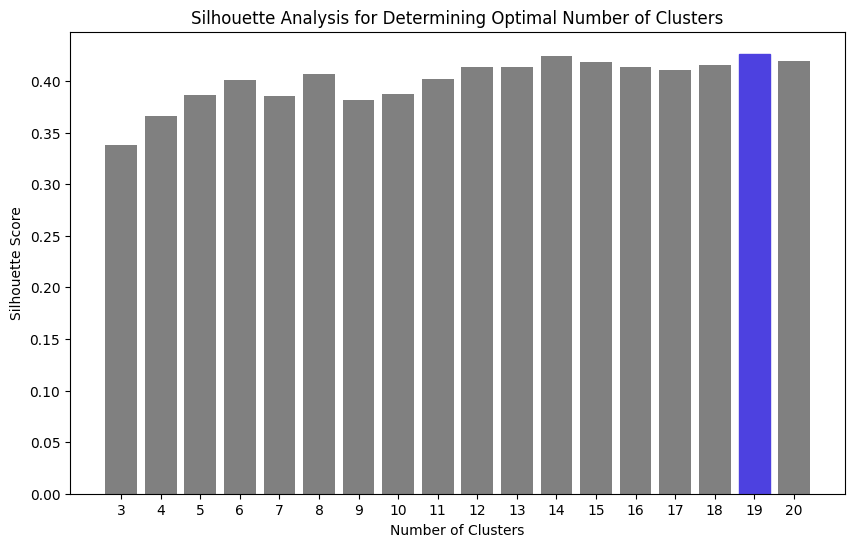

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bars = plt.bar(n_clusters_range, silhouette_scores, color='gray')

max_index = np.argmax(silhouette_scores)
bars[max_index].set_color('#4d41e0')

plt.xticks(n_clusters_range)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Determining Optimal Number of Clusters')

plt.show()

In [37]:
#silhouette_scores

In [38]:
kmeans = cluster_with_max_silhouette[2]
cluster_labels = kmeans.predict(X_train)
df['cluster'] = cluster_labels

In [39]:
df.head()

,tweet_id,clean_text,hug_embeddings,reduced_hug_embeddings,cluster
366545,760061,im having the same problem with my card im tr...,"[-0.006630308, -0.03410908, 0.014129483, -0.01...","[12.958704, 4.9156933]",10
1210882,2419037,for tickets to stand up for hours leeds lond...,"[-0.0072227665, -0.0022063444, -0.017389687, 0...","[12.461964, -2.6646166]",5
1311959,2612483,any prepacked precut fruit. it seems theres a ...,"[0.06532808, -0.02262792, 0.015571611, -0.0130...","[9.409803, 0.10098898]",16
1127687,2259892,mcdonald run,"[-0.032393742, 0.033859327, -0.006859308, -0.0...","[8.405855, -0.4392022]",16
498761,1027628,thanks i have sent you the dm,"[0.047049806, -0.01865189, -0.030001568, 0.020...","[15.27981, 4.452145]",12


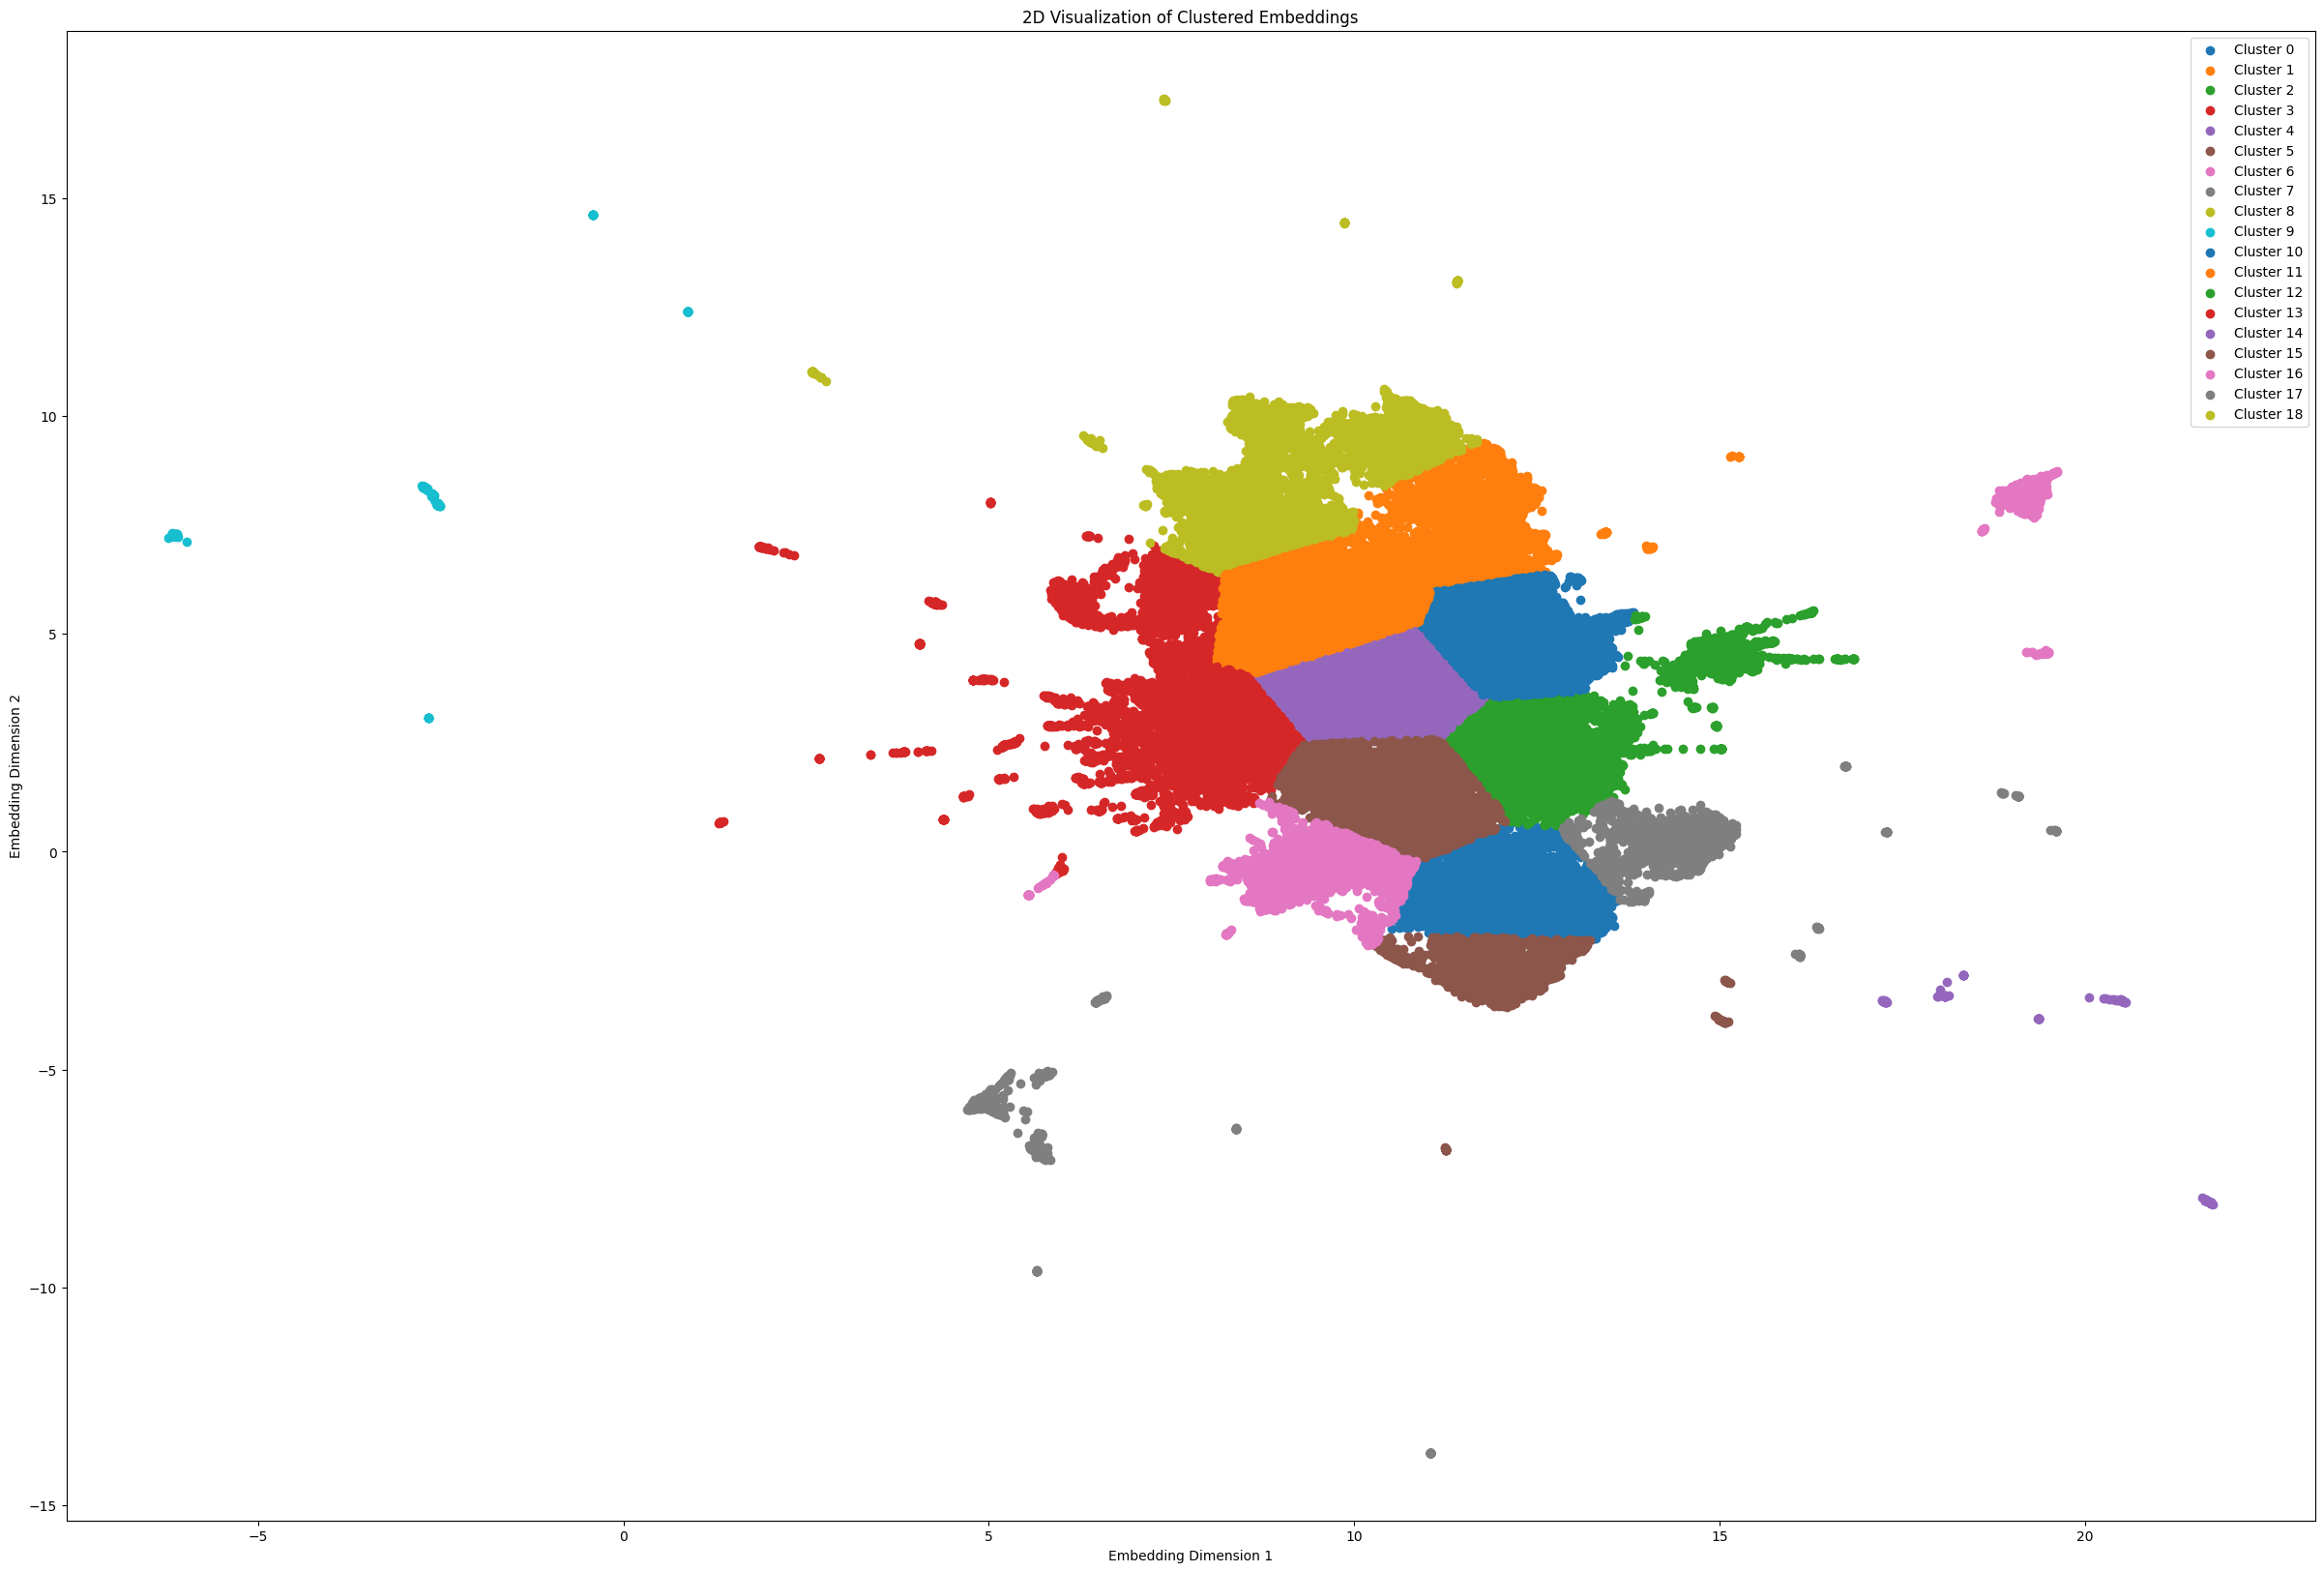

In [41]:
embeddings = np.stack(df['reduced_hug_embeddings'].values)
clusters = df['cluster'].values

unique_clusters = set(clusters)

plt.figure(figsize=(30, 20))

for cluster_id in unique_clusters:
    cluster_indices = np.where(clusters == cluster_id)
    cluster_embeddings = embeddings[cluster_indices]

    x_coords = cluster_embeddings[:, 0]
    y_coords = cluster_embeddings[:, 1]
    plt.scatter(x_coords, y_coords, label=f"Cluster {cluster_id}")

plt.title("2D Visualization of Clustered Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")

plt.legend()
plt.show()

In [ ]:
### Defining names for clusters

In [42]:
# Description: 2-3 sentences of the common theme among all entries.
CLASSIFICATION_PROMPT = """
Given classes with lists of questions and answers. Classify the topic of those questions and answers.
Return the response in the format:
Class name: A noun (1-3 words) that encompasses the description and can be used as the class name during classification.
Do it for all classes.
"""

def classify_group(prompt):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
          {"role": "system", "content": CLASSIFICATION_PROMPT},
          {"role": "user", "content": prompt},
      ],
        temperature=0.5
    )
    return response.choices[0].message.content

In [43]:
cluster_counts = df['cluster'].value_counts(sort=False).sort_index()
cluster_name = []
query = ""

for cluster in cluster_counts.index:
    cluster_content = df[df['cluster'] == cluster]['clean_text'].values[:30]
    prompt = '\n'.join([f"```{issue}```" for issue in cluster_content])
    query += f"class {cluster+1}: {prompt}\n"

In [44]:
cluster_class = classify_group(query)

In [45]:
print(cluster_class)

Class name: Customer Feedback
Class name: Technology Issues
Class name: Transportation Services
Class name: Food and Restaurant Feedback
Class name: Shopping and Delivery Issues
Class name: Entertainment and Streaming Services
Class name: Travel and Accommodation Feedback
Class name: Retail and Product Feedback
Class name: Personal Assistance
Class name: User Satisfaction
Class name: Music and Entertainment Queries
Class name: Ride Sharing Services
Class name: Customer Support
Class name: Music and Streaming Services
Class name: TV and Streaming Problems
Class name: Travel and Transportation Queries
Class name: TV and Streaming Services
Class name: Music and Streaming Services
Class name: TV and Streaming Services
